# Nonlinear Poisson equation

Source: Fenics demo [nonlinear Poisson equation](https://fenicsproject.org/olddocs/dolfin/2019.1.0/python/demos/nonlinear-poisson/demo_nonlinear-poisson.py.html).

Next, we consider a nonlinear version of the Poisson equation to see how we can solve nonlinear variational problems in Fenics. The domain is a two-dimensional square with two circular holes as shown below:

<img src="nonlinear_poisson_setup.png" style="width:400px;">

Consider a two-dimension domain $\Omega = (0,1)^2 - B(\boldsymbol{x}_1, r_1) - B(\boldsymbol{x}_2, r_2)$ shown in the figure above, where $B(\boldsymbol{x}, r)$ is the 2-d ball of radius $r$ centered $\boldsymbol{x}$. Here, $\boldsymbol{x}_1 = (0.2, 0.8), \boldsymbol{x}_2 = (0.7, 0.3), r_1 = 0.1, r_2 = 0.2$. 

Let 
\begin{equation}
\Gamma_{in} := \partial B(\boldsymbol{x}_1, r_1) \cup \partial B(\boldsymbol{x}_2, r_2), 
\end{equation}
where $\partial B(\boldsymbol{x}, r)$ denotes the boundary of ball $B(\boldsymbol{x}, r)$. Further let 
\begin{equation}
\Gamma_{out} = \partial \Omega - \Gamma_{in} = \{(x, y): x \in \{0, 1\}, y \in [0, 1]\} \cup \{(x, y): y \in \{0, 1\}, x \in [0, 1]\}. 
\end{equation}. 

We consider the following nonlinear Poisson equation:
\begin{equation}
-div (\kappa (1+u^2) grad (u(x, y))) = f(x, y) \qquad \text{for } \qquad (x,y) \in \Omega,
\end{equation}
with the source $f$ given by
\begin{equation}
f(x, y) = x \sin(4y)
\end{equation}
and boundary conditions given by
\begin{align}
u &= 0 \qquad \text{ on } \qquad \Gamma_{in} \\
\kappa (1+ u^2) \nabla u \cdot n &= g \qquad \text{ on } \qquad \Gamma_{out}
\end{align}
with $g(x,y) = x^2 + y^2 + 2x^2 y^2$. Here, $\kappa = 0.75$ is the diffusivity constant. 

## Variational formulation
Let $V$ be the suitable function space then the variational problem associated to the above PDE reads: find $u\in V$ such that
\begin{equation}
\underbrace{\int_{\Omega} \kappa (1 + u^2) \nabla u \cdot \nabla v dx}_{=: a(u;v)} = \underbrace{\int_{\Omega} f v dx + \int_{\Gamma_{out}} g v ds}_{=:l(v)} \qquad \text{for } \qquad v \in V.
\end{equation}
In the above $a(u;v)$ is the semilinear form and $l(v)$ is the linear form. Residual of the problem $R(u;v)$ is given by
\begin{equation}
R(u; v) := a(u; v) - l(v).
\end{equation}
Thus the problem can be written as
\begin{equation}
R(u; v) = 0 \qquad \qquad \forall v \in V .
\end{equation}


## Finite element approximation
Let $V_h$ be the finite element function space. Then the finite element approximation reads: find $u_h \in V_h$ such that
\begin{equation}
R(u_h; v_h) = 0 \qquad \text{for all } \qquad v_h \in V_h.
\end{equation}

### Newton's iteration to solve the nonlinear problem
Let $u_k$ is the solution at the $k$th step and we are interested in $\delta u$ such that $u_k + \delta u \approx u$, $u$ being the exact solution such that $R(u; v) = 0$ for all $v$. Suppose $u = u_k + \delta u$. Then Taylor series expansion of $R(u; v)$ around $u_k$ is given by
\begin{equation}
R(u_k + \delta u; v) = R(u_k; v) + \delta_u R(u_k; \delta u, v) + O(||\delta u||^2),
\end{equation}
where $\delta_u R(u; q, v)$ is the variational (G\:ateaux) derivative of $R$ with respect to the first argument and is defined as
\begin{equation}
\delta_u R(u; q, v) = \lim_{\eta \to 0} \frac{R(u + \eta q; v) - R(u; v)}{\eta} .
\end{equation}

Now, setting $R(u_k + \delta u; v) \approx R(u_k; v) + \delta_u R(u_k; \delta u, v) = 0$ gives the equation for the increment $\delta u$ as follows: Given $u_k$, find $\delta u$ such that
\begin{equation}
\delta_u R(u_k; \delta u, v) = - R(u_k; v) \qquad \qquad \text{for all }\quad v\in V.  
\end{equation}

## Fenics implementation
We first import the dolfin package.

In [43]:
# dolfin includes fenics
import dolfin as dl

# for plotting
import matplotlib.pyplot as plt 

### Create mesh
We create a mesh consisting of 32 x 32 squares with each square divided into two triangles and consider a function space based on the specfied order Lagrange interpolation as follows:

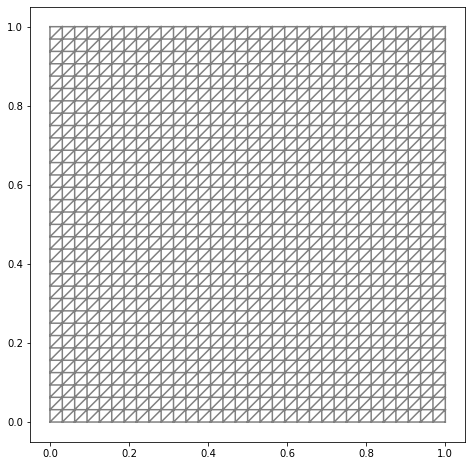

In [44]:
mesh = dl.UnitSquareMesh(32, 32)

# specify order of interpolation
p_order = 2

# create FE function space
V = dl.FunctionSpace(mesh, "Lagrange", p_order) # or dl.FunctionSpace(mesh, "P", p_order)

# plot
plt.figure(figsize=(8,8))
dl.plot(mesh)
plt.show()

### Define boundaries of the domain for boundary conditions

In [45]:
# Define vertical edges (x = 0 or x = 1) for Dirichlet boundary condition
def vert_edges(x):
    return x[0] < dl.DOLFIN_EPS or x[0] > 1.0 - dl.DOLFIN_EPS

# Define horizontal edges (x = 0 or x = 1) for Neumann boundary condition
def horiz_edges(x):
    return x[1] < dl.DOLFIN_EPS or x[1] > 1.0 - dl.DOLFIN_EPS

Next, define surface measure for integration of neumann boundary condition over $\Gamma_N$

In [46]:
facets = dl.MeshFunction("size_t", mesh, 1)

# note we use `horiz_edges` in below
dl.AutoSubDomain(horiz_edges).mark(facets, 1)

# create surface measure
ds = dl.Measure("ds", subdomain_data=facets)

Now, create Dirichlet boundary condition object

In [47]:
u_bdr = dl.Constant(0.0) # use dolfin in-built Constant function

# now actually create boundary condition 
# arg1: function space, arg2: value of boundary condition, arg3: boundary domain
u_bc = dl.DirichletBC(V, u_bdr, vert_edges)

Now, create function $g(x,y) = \sin(5x)$ for Neumann boundary condition

In [48]:
# degree specifies interpolation order when interpolating this function on to the mesh
g = dl.Expression("sin(5*x[0])", degree=2)

### Define bilinear and linear forms
First, create variables for test $v$ and trial $u$ functions:

In [49]:
u_trial = dl.TrialFunction(V)
v_test = dl.TestFunction(V)

Now, create function $f$ for right-hand source term:

In [50]:
f = dl.Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)", degree=2)

Define the diffusivity parameter:

In [51]:
kappa = dl.Constant(0.75)

We are now ready to define bilinear form $a(u,v)$ and linear form $l(v)$:

In [52]:
a = kappa * dl.inner(dl.grad(u_trial), dl.grad(v_test))*dl.dx
L = f*v_test*dl.dx + g*v_test*ds

In the above, `dl.grad` is dolfin in-build function for gradient of variable and `dl.dx` is the measure for integral over the domain.

### Solve the problem a(u,v) = l(v)

In [53]:
u = dl.Function(V, name = 'u') # solution variable

# solve using fenics in-build solve function 
# arg1: variational problem, arg2: solution variable, arg3: boundary condition
dl.solve(a == L, u, u_bc)

Solving linear variational problem.


Save solution and plot result

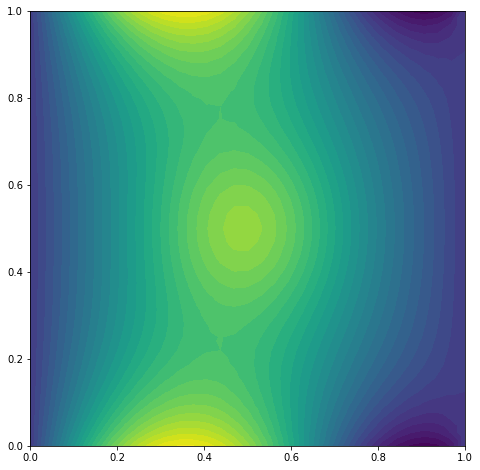

In [54]:
# Save solution in VTK format
file = dl.File("fwd_result/poisson_equation.pvd")
file << u

# Plot solution
plt.figure(figsize=(8,8))
dl.plot(u)
plt.show()

### Plotting in paraview
- load file `poisson_equation.pvd` in paraview
- apply `warp by scalar` filter
- click on `2D` in view panel to change view to `3D`

The result looks as follows

<img src="poisson_equation_result.png" style="width:400px;">

# Solving Poisson equation on complex geometry and mesh from gmsh
We now consider solving the same equation on square domain with a hole. The domain is shown below:

<img src="../meshing/square_with_hole/domain.png" style="width:200px;">

We assume zero Neumann boundary condition on the internal boundary of the hole. Same as in the first example, we assume zero Dirichlet boundary condition on the vertical edges and Neumann boundary condition $du/dn = g$ on the horizontal edges. 

The only thing that will change from the previous example is mesh. We load the `.xdmf` mesh file `mesh_h_0.010.xdmf` from directory [../meshing/square_with_hole_pygmsh](../meshing/square_with_hole_pygmsh) as follows

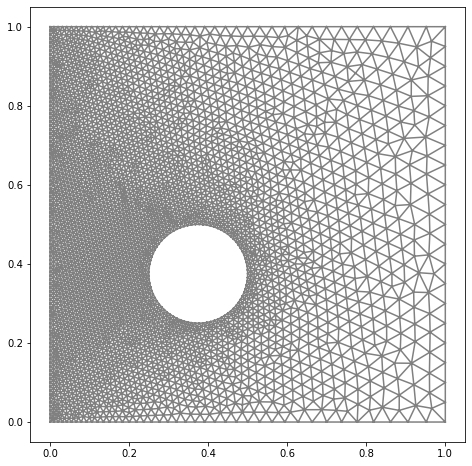

In [55]:
mesh = dl.Mesh()
mesh_fname = '../meshing/square_with_hole_pygmsh/mesh_h_0.010'
# read xdmf file in fenics
with dl.XDMFFile(mesh_fname + '.xdmf') as infile:
    infile.read(mesh)

mvc = dl.MeshValueCollection("size_t", mesh, 2)
with dl.XDMFFile(mesh_fname + '_facet.xdmf') as infile:
    infile.read(mvc, "name_to_read")
    
sub = dl.cpp.mesh.MeshFunctionSizet(mesh, mvc)

# plot
plt.figure(figsize=(8,8))
dl.plot(mesh)

plt.show()

Rest of the code is same as before so we put them all together below:

Solving linear variational problem.


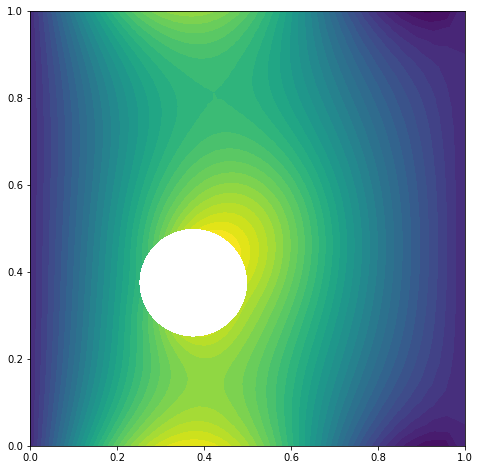

In [56]:
# ---- #
# Function space
# ---- #
# specify order of interpolation
p_order = 2

# create FE function space
V = dl.FunctionSpace(mesh, "Lagrange", p_order) # or dl.FunctionSpace(mesh, "P", p_order)

# ---- #
# Boundary integral measure
# ---- #
facets = dl.MeshFunction("size_t", mesh, 1)

# note we use `horiz_edges` in below
dl.AutoSubDomain(horiz_edges).mark(facets, 1)

# create surface measure
ds = dl.Measure("ds", subdomain_data=facets)

# ---- #
# Dirichlet BC
# ---- #
u_bdr = dl.Constant(0.0) # use dolfin in-built Constant function

# now actually create boundary condition 
# arg1: function space, arg2: value of boundary condition, arg3: boundary domain
u_bc = dl.DirichletBC(V, u_bdr, vert_edges)

# ---- #
# Neumann BC
# ---- #
# degree specifies interpolation order when interpolating this function on to the mesh
g = dl.Expression("sin(5*x[0])", degree=2)

# ---- #
# Variational forms
# ---- #
u_trial = dl.TrialFunction(V)
v_test = dl.TestFunction(V)

f = dl.Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)", degree=2)

kappa = dl.Constant(0.75)

a = kappa * dl.inner(dl.grad(u_trial), dl.grad(v_test))*dl.dx
L = f*v_test*dl.dx + g*v_test*ds

u = dl.Function(V, name = 'u') # solution variable

# ---- #
# Solve
# ---- #
# solve using fenics in-build solve function 
# arg1: variational problem, arg2: solution variable, arg3: boundary condition
dl.solve(a == L, u, u_bc)

# ---- #
# Save solution and plot
# ---- #
# Save solution in VTK format
file = dl.File("fwd_result_complex_geom/poisson_equation.pvd")
file << u

# Plot solution
plt.figure(figsize=(8,8))
dl.plot(u)
plt.show()

In paraview, the result is as follows:
    
<img src="poisson_equation_complex_geom_result.png" style="width:400px;">

# For further readings
- [Original Fenics demo](https://fenicsproject.org/olddocs/dolfin/2019.1.0/python/demos/poisson/demo_poisson.py.html) that this demo is based on 
- More elaborate explanations and discussion of some other topics such as error, nodal values of solution, etc. in this [Fenics demo](https://fenicsproject.org/pub/tutorial/html/._ftut1004.html)